<a href="https://colab.research.google.com/github/mloyorev/Theory/blob/main/7_OptimalSavingsNumba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install quantecon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.8/214.8 kB 4.2 MB/s eta 0:00:00


In [2]:
from collections import namedtuple
import numpy as np
import quantecon as qe
from numba import njit, prange, int32
import matplotlib.pyplot as plt

Once **again** we use the functions:


*   argmax
*   succesive_approx



In [3]:
@njit
def argmax(list_object):
    max_val = -np.inf
    argmax_index = None
    for i, x in enumerate(list_object):
        if x > max_val:
            max_val = x
            argmax_index = i
    return argmax_index

In [4]:
def successive_approx(T,
                      x_0,
                      tolerance=1e-6,
                      max_iter=10_000,
                      print_step=25,
                      verbose=False):
    x = x_0
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"Terminated successfully in {k} iterations.")
    return x


# **Optimal savings model**

We assume that **wealth $W_{t}$ evolves** according to

$$C_{t}+W_{t+1}≤RW_{t}+Y_{t}$$

where $R$ is the gross interest rate, $Y_{t}$ is the labor income and:


*   $(W_{t})$ takes values in a finite set $W$ contained in the set $\mathbb{R}_{+}$
*   $(Y_{t})$ is a **$Q$-Markov chain** on a finite and continuous set $Y$.
*   $C_{t}\geq 0$ for all $t$.

The individual **aims to maximize the present value** of his utility function. Additionally, we suppose that the individual perceive utility from consumption. This means that the consumer's maximization problem is

$$V(w_{t},y_{t})=\max_{\left\{w_{t+\tau+1}\right\}}E_{t}\sum_{\tau=0}^{\infty}\beta^{\tau}u(c_{t})=\max_{\left\{w_{t+\tau+1}\right\}}E_{t}\sum_{\tau=0}^{\infty}\beta^{\tau}u(Rw_{t}+y_{t}-w_{t+\tau+1})$$

Since $E_{t}u(Rw_{t}+y_{t}-w_{t+1})=u(Rw_{t}+y_{t}-w_{t+1})$, this equation can be also expressed as

$$V(w_{t},y_{t})=\max_{w_{t+1}}u(Rw_{t}+y_{t}-w_{t+1})+\max_{\left\{w_{t+\tau+1}\right\}}E_{t}\sum_{\tau=1}^{\infty}\beta^{\tau}u(Rw_{t+\tau}+y_{t+\tau}-w_{t+\tau+1})$$

By making the substitution $\tau=k+1$, we obtain that

$$V(w_{t},y_{t})=\max_{w_{t+1}}u(Rw_{t}+y_{t}-w_{t+1})+\max_{\left\{w_{t+k+2}\right\}}E_{t}\sum_{k=0}^{\infty}\beta^{k+1}u(Rw_{t+k+1}+y_{t+k+1}-w_{t+k+2})$$

$$V(w_{t},y_{t})=\max_{w_{t+1}}u(Rw_{t}+y_{t}-w_{t+1})+\max_{\left\{w_{t+k+2}\right\}}\beta E_{t}\sum_{k=0}^{\infty}\beta^{k}u(Rw_{t+k+1}+y_{t+k+1}-w_{t+k+2})$$

According to the **law of iterated expectations**$^{1}$ this expression can be rewritten as

$$V(w_{t},y_{t})=\max_{w_{t+1}}u(Rw_{t}+y_{t}-w_{t+1})+\max_{\left\{w_{t+k+2}\right\}}\beta ∫_{y_{t+1}}E_{t+1}\left[\sum_{k=0}^{\infty}\beta^{k}u(Rw_{t+k+1}+y_{t+k+1}-w_{t+k+2})\right]f(y_{t+1}|y_{t})dy_{t+1}$$

$$V(w_{t},y_{t})=\max_{w_{t+1}}u(Rw_{t}+y_{t}-w_{t+1})+\beta ∫_{y_{t+1}}\max_{\left\{w_{t+k+2}\right\}}E_{t+1}\left[\sum_{k=0}^{\infty}\beta^{k}u(Rw_{t+k+1}+y_{t+k+1}-w_{t+k+2})\right]f(y_{t+1}|y_{t})dy_{t+1}$$

$$V(w_{t},y_{t})=\max_{w_{t+1}}u(Rw_{t}+y_{t}-w_{t+1})+\beta ∫_{y_{t+1}}V(w_{t+1},y_{t+1})f(y_{t+1}|y_{t})dy_{t+1}$$

Finally, **by definition**, we have that

$$V(w,y)=\max_{w'}u(Rw+y-w')+\beta E_{t}V(w',y')$$

which represents the **Bellman equation** for the stochastic dynamic programin problem of the optimal investment problem.

Once we define the model we introduce the functions needed to define the default value of the model parameter.

Additional to this functions, we suppose that the set $Y$ is discrete, such that the Bellman equation can be written as

$$V(w,y)=\max_{w'}u(Rw+y-w')+\beta \sum_{y'\in Y}V(w',y')Q(y,y')$$

where $Q(y,y')$ represents the transition matrix, and that the utility function can be described as

$$u(c)=\frac{c^{1+\gamma}}{1+\gamma}$$

In [5]:
Model = namedtuple('Model', ('beta',    # Discount factor
                             'R',       # Gross interest rate
                             'gamma',   # CRRA parameter
                             'w_grid',  # Wealth grid
                             'y_grid',  # Labor income grid
                             'Q'))      # Labor income transition matrix

In [6]:
def create_consumption_model(R=1.01,          # Gross interest rate
                             beta=0.98,       # Discount factor
                             gamma=2.5,       # CRRA parameter
                             w_min=0.01,      # Min wealth
                             w_max=5.0,       # Max wealth
                             w_size=150,      # Size of the wealth grid
                             rho=0.9, nu=0.1, # Income parameters
                             y_size=100):     # Size of the income grid

    w_grid = np.linspace(w_min, w_max, w_size)   # Create the wealth grid
    mc = qe.tauchen(rho=rho, sigma=nu, n=y_size) # 'qe.tauchen' computes a Markov chain associated with a discretized version of the linear Gaussian AR(1) process
                                                 #    - rho is the autocorrelation coefficient
                                                 #    - nu is the standard deviation of the random process
    y_grid, Q = np.exp(mc.state_values), mc.P    # - 'y_grid' is the grid of transformed income values
                                                 # - 'Q' is the transition matrix describing transition probabilities between discrete income values ​​in the stochastic process

    return Model(beta=beta, R=R, gamma=gamma, w_grid=w_grid, y_grid=y_grid, Q=Q)

Here's the RHS of the unmaximized Bellman equation

In [7]:
@njit
def B(i, j, ip, v, model):

    β, R, γ, w_grid, y_grid, Q = model          # Unpacked model parameters
    w, y, wp = w_grid[i], y_grid[j], w_grid[ip] # We use:
                                                #  - index i for access the value of current wealth within the wealth grid
                                                #  - index j for access the value of income within the income grid
                                                #  - index ip foe acces the value of next period wealth within the wealth grid
    c = R * w + y - wp
    if c > 0:
        return c**(1 - γ) / (1 - γ) + β * np.dot(v[ip, :], Q[j, :])
    return - np.inf

In order to solve this model, we have to prove that it satisfies the **Blackwell sufficiency conditions**.

### **1. Monotonicity**
Let $V,W$ two different functions that satisfy that $V(w,y)≤W(w,y)
$ $∀w,y$. If we name $w',y'$ the wealth and the labor income shock of the next period then...

$$V(w',y')≤W(w',y'),  ∀w',y'$$

If we multiply both sides of the inequality by the transition probability matrix, then...

$$V(w',y')Q(y,y')≤W(w',y')Q(y,y'),  ∀w',y'$$

The inequality also holds for the expected value of value functions, such that...

$$\sum_{y'}V(w',y')Q(y,y')≤\sum_{y'}W(w',y')Q(y,y')$$
$$β\sum_{y'}V(w',y')Q(y,y')≤β\sum_{y'}W(w',y')Q(y,y')$$

Finally we add both sides the maximization of the current utility given a particular level of current wealth and income shock, such that...

$$\max_{w'}u(w,y,w')+β\sum_{y'}V(w',y')Q(y,y')≤\max_{w'}u(w,y,w')+β\sum_{y'}W(w',y')Q(y,y')$$

Therefore, $T(V(w,y))≤T(W(w,y)), ∀w,y$, which means that the transformation **satisifes monotonicity**.

### **2. Discounting**
Let's consider a value function $V$ and a positive constant $a$, such that...

$$T(V(w,y)+a)=\max_{w'}u(w,y,w')+β∑_{y'}(V(w',y')+a)Q(y,y')$$



$$T(V(w,y)+a)=\max_{w'}u(w,y,w')+β∑_{y'}(V(w',y'))Q(y,y')+β∑_{y'}aQ(y,y')$$



$$T(V(w,y)+a)=\max_{w'}u(w,y,w')+β∑_{y'}(V(w',y'))Q(y,y')+aβ∑_{y'}Q(y,y')$$

it is fulfilled that $∑_{y'}Q(y,y')=1$, such that...

$$T(V(w,y)+a)=\max_{w'}u(w,y,w')+β∑_{y'}(V(w',y'))Q(y,y')+aβ$$



$$T(V(w,y)+a)=T(V(w,y))+aβ$$

Therefore, $T(V(w,y)+a)≤T(V(w,y))+aβ$, which means that the transformation satisfies discounting.


Since we already know that the model satisfies the Blackwell sufficiency conditions, then we are now sure that **there is a solution and that it is unique**.

Unlike previous notebooks, we will now solve the model with **three different algorithms**:


*   Value Function Iteration (VFI).
*   Howard Policy Iteration (HPI).
*   Optimistic Policy Iteration (OPI).



In order to be able to use this algorithms, we have to define the policy operator $T_{\sigma}$, the Bellman operator $T$ and the $v-$greedy policy given $v$.

In [8]:
# POLICY OPERATOR

@njit(parallel=True)          # It is compiled with numba and the inner loop can be parallelized with multiple CPU cores
def T_sigma(v, sigma, model):

    w_size, y_size = len(model.w_grid), len(model.y_grid) # Obtain the size of the wealth and income grids
    v_new = np.empty_like(v)                              # Initialize a value fuction of the size of the 'v' array

    for i in prange(w_size):                              # Iterates through the i indices of the wealth grid
                                                          # 'prange(w_size)' indicates that the loop can be paralelized
        for j in range(y_size):                           # Iterates through the j indices of the income grid
            v_new[i, j] = B(i, j, sigma[i, j], v, model)  # It gets the value of each possible combination of wealth and income
                                                          # Notiche that:
                                                          #   - i is the index of current wealth
                                                          #   - j is the index of the current income
                                                          #   - 'sigma[i, j]' is the next period wealth given the indices of current wealth and income
    return v_new

In [9]:
# BELLMAN OPERATOR

@njit(parallel=True)
def T(v, model):

    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    v_new = np.empty_like(v)

    for i in prange(w_size):
        for j in range(y_size):
            v_new[i, j] = max([B(i, j, ip, v, model) for ip in range(w_size)])  # It gets the value of each possible combination of wealth and income
                                                                                # Notiche that:
                                                                                #   - i is the index of current wealth
                                                                                #   - j is the index of the current income
                                                                                #   - ip is the next period wealth
    return v_new

In [10]:
# V-GREEDY POLICY GIVEN V

@njit(parallel=True)
def get_greedy(v, model):

    β, R, γ, w_grid, y_grid, Q = model
    w_size, y_size = len(w_grid), len(y_grid)
    σ = np.empty_like(v, dtype=int32)

    for i in prange(w_size):
        for j in range(y_size):
            σ[i, j] = argmax([B(i, j, ip, v, model) for ip in range(w_size)]) #   For each pair (i,j), we obtain the index ip that maximize
                                                                              # the Bellman equation.
    return σ

The function below computes the value $v_{\sigma}$ of following a policy $\sigma$.

In order to compute the value of a policy, we have to solve the linear system

$$v(w,y)=u(Rw+y-\sigma(w,y))+β\sum_{y'}v(\sigma(w,y),y')Q(y',y)$$

for $v$.

Therefore, it turns out helpul to rewrite this system as

$$v(w,y)=r(w,y,\sigma(w,y))+β\sum_{w',y'}v(w',y')P_{\sigma}(w,y,w',y')$$

where $P_{\sigma}(w,y,w',y')=1\left\{w'=\sigma(w,y)\right\}Q(y',y)$

Thus the linear system can be simplied as

$$v=r_{\sigma}+P_{\sigma}Q(y',y)$$

and the solve for $v$.

Notice that:

*   $v$ is a $2$ index array.
*   $P_{\sigma}$ is a $4$ index array.

Then, the code below:

1.   Reshapes $v$ and $r_{\sigma}$ to 1D arrays and $P_{\sigma}$ to a matrix.
2.   Solves the linear system.
3.   Converts back to multi-index arrays.





In [11]:
# GET THE VALUE V_SIGMA OF POLICY SIGMA

@njit(parallel=True)
def get_value(sigma, model):

    # Unpack and set up
    beta, R, gamma, w_grid, y_grid, Q = model
    nw, ny = len(w_grid), len(y_grid)
    n = nw * ny

    # Allocate and create multi-index versions of P_σ and r_σ
    P_sigma = np.zeros((nw, ny, nw, ny)) # Initialize the array P_sigma with 4 dimensions
    r_sigma = np.zeros((nw, ny))         # Initialize the array r_simga with 2 dimensions
    for i in range(nw):
        for j in range(ny):
            w, y, wp = w_grid[i], y_grid[j], w_grid[sigma[i, j]]  # Get into each position of wealth and income
            c = R * w + y - wp                                    # Obtain the feasible level of consumption
            r_sigma[i, j] = c**(1 - gamma) / (1 - gamma)          # Get the utility level of each feaible level of consumotion
            for ip in range(nw):
                for jp in range(ny):
                    if ip == sigma[i, j]:                         # If w'=sigma(w,y), then  P_sigma[i, j, ip, jp] = Q[j, jp]
                        P_sigma[i, j, ip, jp] = Q[j, jp]

    # Reshape to standard matrix algebra form
    r_sigma = r_sigma.reshape((n,))
    P_sigma = P_sigma.reshape((n, n))

    # Solve for the value of σ
    I = np.identity(n)
    v_sigma = np.linalg.solve(I - beta * P_sigma, r_sigma)   # Solves the lineas system given by [I - beta * P_sigma]v_sigma=r_sigma

    # Return as multi-index array
    return np.reshape(v_sigma, (nw, ny))

Now we are able to define the solvers for each algorithm.

### **1. Value Function Iteration (VFI)**

The VFI algorithm have already been described previously in the `2_NeoclasicalOptimalGrowthModel.ipynb` notebook.

We introduce a function that implements VFI.

In [12]:
def value_iteration(model, tol=1e-5):
  v0 = np.zeros((len(model.w_grid), len(model.y_grid)))                  # Initial guess
  v_star = successive_approx(lambda v: T(v, model), v0, tolerance = tol) # Succesive approximation algorithm
  return get_greedy(v_star, model)                                       # Returns the optimal policy

### **2. Howard Policy Iteration (HPI)**

The HPI algorithm may be **described as follows:**


1.   Set an initial feasible set of decision rule for the control variable $y=f_{0}(x,s_{k}), k=0,1,...,M$.
2.   Compute the value of $y=f_{0}(x,s_{k})$, assuming that this rule is operative forever, taking care of the fact that $x_{t+1}=h(x_{t},f_{i}(x_{t},s_{t}),s_{t})$ with $i_0$.
3.   Set a stopping criterion $ε>0$.
4.   Find a new policy rule $y=f_{i+1}(x,s_{k})$, such that

$$f_{i+1}(x,s_{k})\in\text{arg}\max_{y}u(y,x,s_{k})+\beta \sum_{j=1}^{M}\pi_{kj}V(h(x_{t},f_{i}(x_{t},s_{t}),s_{t}),s'_{j})$$
5.   Check if $||f_{i+1}(x,s)-f_{i}(x,s)||<ɛ$, if yes then stop, else go back to step 2.

Notice that this methos **differs fundamentally from the VFI** algorithm in at least two dimensions:


1.   Iterates on the policy function rather than on the value function.
2.   The decision rule is used forever whereas it is assumed inly two consecutive periods in the VFI algorithm. This is precisely what accelerates convergence.

As we mentioned above, note that when computing the value function we actually have to solve a linear system of the form

$$v(w,y)=u(Rw+y-\sigma(w,y))+β\sum_{y'}v(\sigma(w,y),y')Q(y',y)$$

for $v$.

Usually HPI requieres only few iterations. Unfortunately, we have to solve a relatively difficult linear system, which **may be particularly costly** when the number of grid points is important.

Therefore, a number of researchers has proposed to replace the matrix inversion by an additional iteration step, leading to the so-called **Optimistic Policy Iteration (OPI)**.





In [13]:
def policy_iteration(model):
    w_size, y_size = len(model.w_grid), len(model.y_grid)
    sigma = np.zeros((w_size, y_size), dtype=int)             # Initial guess
    i, error = 0, 1.0                                         # Initialize iterations and error
    while error > 0:
        v_sigma = get_value(sigma, model)                # Get the value of the policy guess
        sigma_new = get_greedy(v_sigma, model)           # Updates the policy given the value of the previous policy
        error = np.max(np.abs(sigma_new - sigma))        # Updates error
        sigma = sigma_new                                # Updates policy
        i = i + 1                                        # Updates number of iterations
        print(f"Concluded loop {i} with error {error}.")

    return sigma

### **3. Optimistical Policy Iteration (OPI)**

The OPI algorithm may be **described as follows:**

1.   Set $J_{0}=V_{i}$.
2.   Iterates $m\in\mathbb{N}$ times on

$$J_{i+1}=u(y,x)+\beta QJ_{i}$$

3.   Set $V_{i+1}=J_{k}$ and compute the error $||V_{i+1}-V_{i}||$.
4.   If the error is lower than the convergence criterion, then we have arrive to the solution, otherwise return to the step 2.

**Regarding $m$,**


*   $m→\infty⇒OPI=HPI$
*   $m=1⇒OPI=VFI$

Often an intermediate value of $m$ is better than both.



In [14]:
def optimistic_policy_iteration(model, tol=1e-5, m=100):
  v = np.zeros((len(model.w_grid), len(model.y_grid))) # Initial guess of the value function
  error = tol + 1                                      # Initialize the error

  while error > tol:
      last_v = v
      sigma = get_greedy(v, model)          # Get the policy associated with the guess of the value function
      for _ in range(m):                    # Apply the policy operator m times
        v = T_sigma(v, sigma, model)        # Update the value function
        error = np.max(np.abs(v - last_v))  # Update the error
  return get_greedy(v, model)

Here's a quick test of the timing of each algorithm.

In [15]:
model = create_consumption_model()

In [18]:
print("Starting VFI.")
qe.tic()
out = value_iteration(model)
elapsed = qe.toc()
print(out)
print(f"VFI completed in {elapsed} seconds.")

Starting VFI.
TOC: Elapsed: 0:01:10.08
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
VFI completed in 70.08282566070557 seconds.


In [16]:
print("Starting HPI.")
qe.tic()
out = policy_iteration(model)
elapsed = qe.toc()
print(out)
print(f"HPI completed in {elapsed} seconds.")

Starting HPI.
Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
TOC: Elapsed: 0:09:1.80
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
HPI completed in 541.8053712844849 seconds.


In [23]:
print("Starting OPI.")
qe.tic()
out = optimistic_policy_iteration(model, m=5)
elapsed = qe.toc()
print(out)
print(f"OPI completed in {elapsed} seconds.")
np.shape(out)

Starting OPI.
TOC: Elapsed: 0:00:15.02
[[  0   0   0 ...  20  21  22]
 [  0   0   0 ...  21  22  23]
 [  0   0   0 ...  22  23  24]
 ...
 [133 133 133 ... 149 149 149]
 [134 134 134 ... 149 149 149]
 [135 135 135 ... 149 149 149]]
OPI completed in 15.026402473449707 seconds.


(150, 100)

Notice that the optimal policy is a matrix of dimesions $150\times100$, which are exactly the number of gridpoints on the wealth and income grid.

This means that the **optimal policy returns the optimal wealth on the next period** given all the possible combinations of current wealth and income.

This interpretation can be illustrated by means of the following **heat graph**.

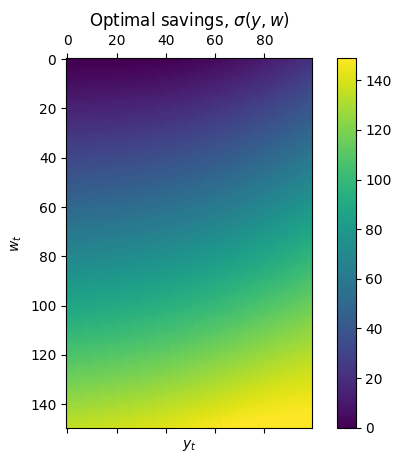

In [26]:
def plot_heatmap(out):
    fig, ax = plt.subplots()                       # Create a figure and an axis
    cax = ax.matshow(out, cmap='viridis')          # Create the heat graph
    ax.set_xlabel('$y_{t}$')                       # Set the axis labels
    ax.set_ylabel('$w_{t}$')
    ax.set_title('Optimal savings, $\sigma(y,w$)') # Set the title
    plt.colorbar(cax)                              # Add heat graph color bar
    plt.show()

plot_heatmap(out)

Furthermore, we can create a graph that model the **timing of the three algorithms** when the step size $m\in\mathbb{N}$ of the OPI algorithm changes.

This exercise will be helpful to understand the relation between OPI, VFI and HPI that we mentioned above.

Concluded loop 1 with error 77.
Concluded loop 2 with error 55.
Concluded loop 3 with error 28.
Concluded loop 4 with error 17.
Concluded loop 5 with error 7.
Concluded loop 6 with error 3.
Concluded loop 7 with error 1.
Concluded loop 8 with error 1.
Concluded loop 9 with error 0.
TOC: Elapsed: 0:09:32.79
TOC: Elapsed: 0:01:23.16
TOC: Elapsed: 0:00:16.30
OPI with m=5 completed in 16.30424213409424 seconds.
TOC: Elapsed: 0:00:3.01
OPI with m=205 completed in 3.0114188194274902 seconds.
TOC: Elapsed: 0:00:5.42
OPI with m=405 completed in 5.421709299087524 seconds.
TOC: Elapsed: 0:00:6.53
OPI with m=605 completed in 6.5341575145721436 seconds.
TOC: Elapsed: 0:00:9.04
OPI with m=805 completed in 9.041853427886963 seconds.
TOC: Elapsed: 0:00:11.62
OPI with m=1005 completed in 11.629588842391968 seconds.
TOC: Elapsed: 0:00:17.23
OPI with m=1205 completed in 17.2313449382782 seconds.
TOC: Elapsed: 0:00:18.90
OPI with m=1405 completed in 18.90538454055786 seconds.
TOC: Elapsed: 0:00:20.12
OPI

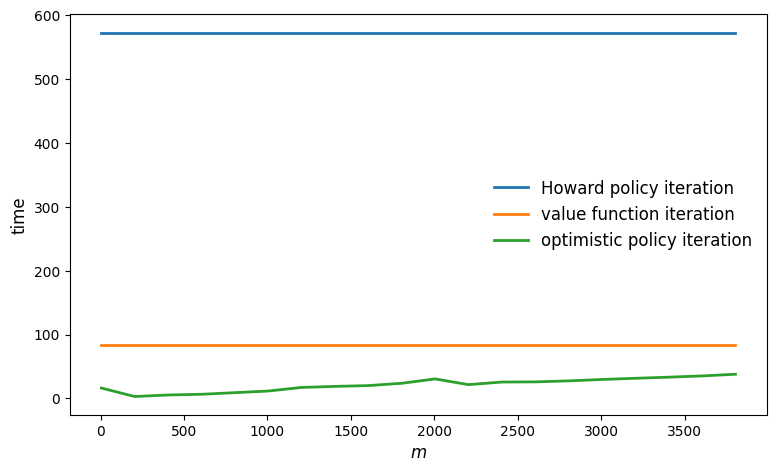

In [27]:
# HPI ALGORITHM
qe.tic()
sigma_pi = policy_iteration(model)
pi_time = qe.toc()

# VFI ALGORITHM
qe.tic()
sigma_vfi = value_iteration(model, tol=1e-5)
vfi_time = qe.toc()

# OPI ALGORITM
m_vals = range(5, 4000, 200)
assert np.all(sigma_vfi == sigma_pi), "Warning: VFI policy deviated from true policy."
opi_times = []
for m in m_vals:
    qe.tic()
    sigma_opi = optimistic_policy_iteration(model, m=m, tol=1e-5)
    opi_time = qe.toc()
    print(f"OPI with m={m} completed in {opi_time} seconds.")
    assert np.all(sigma_opi == sigma_pi), "Warning: OPI policy deviated."
    opi_times.append(opi_time)

fig, ax = plt.subplots(figsize=(9, 5.2))
ax.plot(m_vals, np.full(len(m_vals), pi_time),
        lw=2, label="Howard policy iteration")
ax.plot(m_vals, np.full(len(m_vals), vfi_time),
        lw=2, label="value function iteration")
ax.plot(m_vals, opi_times, lw=2, label="optimistic policy iteration")
ax.legend(fontsize=12, frameon=False)
ax.set_xlabel("$m$", fontsize=12)
ax.set_ylabel("time", fontsize=12)
plt.show()

Finally, as a more practical exercise, we create a function that given the model parameters and a selected algorithm, **solves the optimal savings model** and return the optimal savings matrix and graph.

In [29]:
def optimal_savings(parameters, vfi=True, hpi=False, opi=False):
  print('Starting the solution of the model with the selected algorithm.')
  qe.tic()

  if vfi==True and hpi==False and opi==False:
    out = value_iteration(parameters)
  elif vfi==False and hpi==True and opi==False:
    out = policy_iteration(parameters)
  elif vfi==False and hpi==False and opi==True:
    out = optimistic_policy_iteration(parameters, m=205)
  else:
    raise ValueError('Only one of the algorithms must be chosen.')

  elapsed = qe.toc()
  print(f'Completed in {elapsed} seconds')

  plot_heatmap(out)
  return out

For example, imagine a new situation in which $R=1.18$ and $ν=0.5$.

Starting the solution of the model with the selected algorithm.
TOC: Elapsed: 0:00:4.17
Completed in 4.172133207321167 seconds


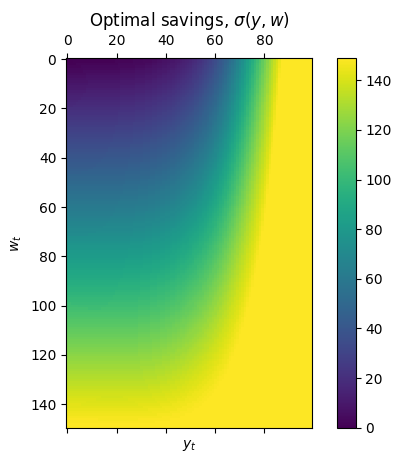

array([[  0,   0,   0, ..., 149, 149, 149],
       [  0,   0,   0, ..., 149, 149, 149],
       [  1,   1,   1, ..., 149, 149, 149],
       ...,
       [148, 148, 148, ..., 149, 149, 149],
       [149, 149, 149, ..., 149, 149, 149],
       [149, 149, 149, ..., 149, 149, 149]], dtype=int32)

In [40]:
model1 = create_consumption_model(R=1.18, nu=0.5)
optimal_savings(model1, vfi=False, opi=True)